# Spurious-Free Dynamic Range (SFDR)

Bei der digitalen Signalverarbeitung hat man es ja nicht nur mit diskreten **Abtastzeiten** zu tun, sondern auch mit diskreten **Amplitudenschritten**, und das führt zu spektralen Störungen. Diese spektralen Störungen ("**Spurs"**) sind immer da, auch wenn die Zeit- und Amplitudenschritte eines ADCs oder DACs alle perfekt sind.

Eine Analogspannung, die mit einem ADC diskreter Auflösung gemessen wird, sei er auch noch so perfekt, stimmt ja nur in einem unendlich kleinen Intervall mit dem ADC überein, nämlich nur dann, wenn exakt eine ADC-Stufe getroffen wird. Darüber und  darunter weicht die Analogspannung von dem Wert ab, den die ADC-Stufe repräsentiert, und alleine diese Abweichungen zwischen der kontinuierlichen Realität und dem ADC-Wert erzeugen schon spektrale Störungen. Darum geht es in dem Kapitel 2.5.2 des SDR-For-Engineers-Buchs: Störungen im Spektrum aufgrund einer endlichen Auflösung des Sampling- und Quantisierungsprozesses.

Im Buch *Software Defined Radio for Engineers*, das man [hier](https://www.analog.com/en/education/education-library/software-defined-radio-for-engineers.html) angucken kann, und im zugehörigen [Github-Repository](https://github.com/sdrforengineers) findet man zu Kapitel 2.5.5 die Skripts *sfdr_example.m* und *sfdr_test.m*.

Im Folgenden versuche ich, die MATLAB-Skripts in Python umzusetzen:

## SFDR in MATLAB vs. Python

MATLAB stellt zur Untersuchung und Darstellung der oben genannten Effekte die Funktion **sfdr(x, fs)** zu Verfügung, die im Buch ab Kapitel 2.5.2 auch ausführlich benutzt wird. Unter dem **Spurious-Free Dynamic Range** (SFDR) versteht man den Abstand der Leistung eines gewollten (Träger-)Signals zum höchsten Störsignal, das im Spektrum auftritt, gemessen in dB.

Trotz intensiver Suche habe ich leider keine Entsprechung für diese MATLAB-Funktion in **numpy**, **scipy**, **pandas** oder anderen Python-Bibliotheken gefunden. Deshalb hab ich versucht, eine möglichst ähnliche Funktion selber zu schreiben. Dabei habe ich wieder einiges gelernt:

Mein erster Versuch sah so aus:

In [6]:
# First naive version of sfdr(x):
def sfdr(x,fs):
    Y = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(len(x), d=1.0/fs)
    mag = np.abs(Y)
    YdB = 20 * np.log10(mag)
    fig, ax = plt.subplots()
    ax.plot(freqs, YdB)


Zum Testen rufen wir die Funktion auf dieselbe Weise auf wie in *sfdr_test.m*:

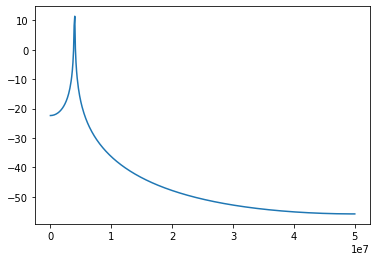

In [7]:
import matplotlib.pyplot as plt
import numpy as np
 
deltat = 1e-8
fs = 1/deltat
t = np.arange(0, 1e-5-deltat, deltat)
fundamental = 3959297 # Prime number
x = 10e-3*np.sin(2*np.pi*fundamental*t)
sfdr(x,fs)

Leider sieht das Ergebnis völlig anders aus als im SDR-Buch!
Man beachte zum Vergleich die Figure 2.28 auf Seite 53 in [dieser PDF-Datei des Buches!](https://www.analog.com/media/en/training-seminars/design-handbooks/Software-Defined-Radio-for-Engineers-2018/SDR4Engineers_CH02.pdf#page=14)
Der Dynamikbereich des Python-Plots oben umfasst mal gerade 70 dB oder so, während der Dynamikbereich des Plots mit MATLAB im Buch ungefähr 300 dB umfasst!
Woran liegt das?
                                                                                         

Im obigen Python-Code wird eine Primzahl als Frequenz (3.959297 MHz) bei einer Abtastfrequenz von 100 MHz und 1000 Abtastwerten verwendet. Der Schwingungszug der mit diesen Parametern erzeugt wird (siehe Codezeile 17) fängt zwar mit der Phase 0 an, hört aber wegen dieser Primzahl nicht so auf, dass der gedachte 1001. Abtastwert wieder mit der Phase 0 fortgesetzt werden kann.
Das schauen wir uns gleich mal mit ein paar Python-Kommandos an:

(0, 3e-07)

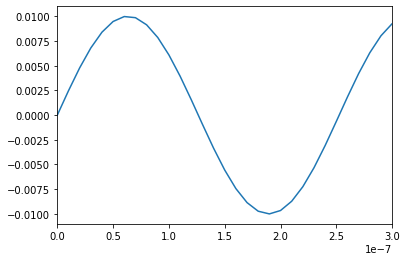

In [11]:
fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlim(0,3e-7)

Das ist der Anfang unseres Datensatzes. Wie oben bereits gesagt, beginnt die Schwingung mit der Phase NULL (und der Amplitude NULL).
Wie sieht es denn am Ende aus?

(9.7e-06, 1e-05)

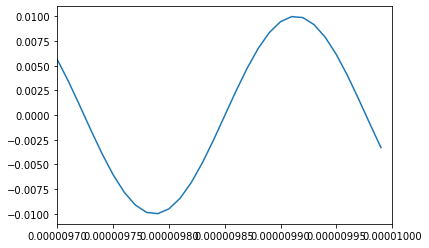

In [14]:
fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlim(1000*1e-8 - 3e-7, 1000*1e-8)

Wie man sieht, hört der Schwingungszug mit einer deutlich negativen Amplitude auf. Der 1001. Abtastwert ist also ungleich 0, oder anders ausgedrückt, die Anzahl der Schwingungen, die in unseren Datensatz hineinpasst, ist keine ganze Zahl.
Wenn der Schwingungszug periodisch fortgesetzt wird, kommt es an den Stoßstellen zu Sprüngen der Amplitude. Im Spektralbereich führt das zu einer Verschmierung der Amplituden, weil die Frequenzbins nicht mehr exakt getroffen werden.
Im Zeitbereich kann man sich einen endlichen langen Schwingungszug als Produkt aus einem unendlich langen Schwingungszug und einer Rechteckfunktion vorstellen: Der unendlich lange Schwingungszug, z.B. eine Sinusschwingung, würde im Spektralbereich eine Delta-Funktion darstellen, d.h. bei allen Frequenzen wären die Amplituden gleich NULL außer bei exakt der Frequenz der Sinusschwingung. Diese Delta-Funktion muss mit der Fouriertransformierten der Rechteck-Funktion, also der sinc-Funktion, gefaltet werden. Das führt zu spectral leakage, und dieses "Herüberschwappen" in falsche Frequenzbereiche kann man gut sehen. https://de.wikipedia.org/wiki/Leck-Effekt